In [21]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing, model_selection
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from transformers import BertModel, BertTokenizer

from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer
import transformers

import time
import matplotlib.pyplot as plt

In [22]:

NUM_EPOCHS = 5
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 8

TEST_SIZE = 0.2

In [23]:
# path = '../data/restaurants_laptop_train_with_pos_task1.csv'
# MODEL_PATH = "model.task1.no_clean.bin"

path = '../data/restaurants_laptop_train_with_pos_task1_cleaned.csv'
MODEL_PATH = "model.task1.cleaned.bin"

df = pd.read_csv(path)

df = df[:200]

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

print('The aspect term encoded numeric is: {}'.format(np.where(encoder.classes_ == "AT")[0].item()))

num of aspect tags: 2
The aspect term encoded numeric is: 0


In [24]:
df

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,1,0
1,s_1,charge,VERB,1,0
2,s_1,it,PRON,1,0
3,s_1,at,ADP,1,0
4,s_1,night,NOUN,1,0
...,...,...,...,...,...
195,s_9,never,ADV,1,0
196,s_9,know,VERB,1,0
197,s_9,about,ADP,1,0
198,s_9,the,DET,1,0


In [25]:
idx = 49
print("Tokens: {}".format(sentences[idx]))
print("Labels: {}".format(aspect_tags[idx]))

IndexError: index 49 is out of bounds for axis 0 with size 9

In [26]:
s = 0
for i in range(10):
    for j in range(s,len(sentences)):
        if len(sentences[j]) < 12:
            print(j)
            print(sentences[j])
            print(aspect_tags[j])
            s = j+1
            break

5
['Great', 'laptop', 'that', 'offers', 'many', 'great', 'features']
[1, 1, 1, 1, 1, 1, 0]


In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = to_device(v, device)
        return data
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:

device = get_default_device()
print(device)


NUM_ASPECT_TAGS = len(encoder.classes_)

# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

cuda


In [29]:
class SentenceTagDataset(Dataset):
    def __init__(self, tokenizer, sentences, aspect_tags, aspect_term_tag, 
                 max_length=128):
        self.sentences = sentences
        self.aspect_tags = aspect_tags
        self.aspect_term_tag = aspect_term_tag
        self.max_length = max_length
        self.special_token = -100

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]  # Get a sentence
        aspect_tags = self.aspect_tags[idx]  # Get the corresponding aspect tags

        sentence_encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        word_ids = sentence_encoding.word_ids(batch_index=0)
        aspect_tags_encoding = []
        previous_word_idx = None
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                aspect_tags_encoding.append(self.special_token)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                aspect_tags_encoding.append(aspect_tags[word_idx])
            else:
                aspect_tags_encoding.append(self.special_token)
            previous_word_idx = word_idx
        aspect_tags_encoding = torch.LongTensor(aspect_tags_encoding)

        return {
            "input_ids": sentence_encoding["input_ids"][0],
            "attention_mask": sentence_encoding["attention_mask"][0],
            "token_type_ids": sentence_encoding["token_type_ids"][0],
            "aspect_tags": aspect_tags_encoding,
        }
    


In [30]:
def loss_fn(output, target, mask, num_labels):
    cel = nn.CrossEntropyLoss()
    masking = mask.view(-1) == 1
    pred = output.view(-1, num_labels)
    true = torch.where(masking, target.view(-1), 
                       torch.tensor(cel.ignore_index).type_as(target))
    
    loss = cel(pred, true)
    return loss

class AspectExtractionModel(nn.Module):
    def __init__(self, num_aspect_tags, num_vocab):
        super(AspectExtractionModel, self).__init__()
        self.num_aspect_tags = num_aspect_tags
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-cased")        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, self.num_aspect_tags)
        # if the number of vocab has been increased, then need to add the new vector 
        # at the end of the embedding matrix
        self.bert_model.resize_token_embeddings(num_vocab)
                
    def forward(self, input_ids, attention_mask, token_type_ids, aspect_tags):
        out, pool_out = self.bert_model(input_ids, attention_mask = attention_mask, 
                                 token_type_ids = token_type_ids, return_dict=False)
        
        tag_out = self.dropout(out)
        tag_out = self.fc(tag_out)
        
        loss_tag = loss_fn(tag_out, aspect_tags, attention_mask, self.num_aspect_tags)
        
        s = nn.Softmax(dim=2)
        
        tag_out = s(tag_out)
        
        return tag_out, loss_tag

In [31]:
def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[true_tags!=-100]
    true_tags = true_tags[true_tags!=-100]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm



In [32]:
(train_sentences, test_sentences, 
 train_aspect_tags, test_aspect_tags) = model_selection.train_test_split(
    sentences, aspect_tags, random_state = 42, test_size = TEST_SIZE)

train_sentences.shape, test_sentences.shape, train_aspect_tags.shape, test_aspect_tags.shape

((7,), (2,), (7,), (2,))

In [33]:
idx = 2
print(train_sentences[idx])
print(train_aspect_tags[idx])


['In', 'the', 'shop', 'these', 'MacBooks', 'are', 'encased', 'in', 'a', 'soft', 'rubber', 'enclosure', 'so', 'you', 'will', 'never', 'know', 'about', 'the', 'razor']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [34]:
train_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=train_sentences, 
                                   aspect_tags=train_aspect_tags,
                                   aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE), device)    

test_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=test_sentences, 
                                  aspect_tags=test_aspect_tags,
                                  aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
test_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE), device)   

model = to_device(AspectExtractionModel(num_aspect_tags = NUM_ASPECT_TAGS, 
                                        num_vocab = len(tokenizer)), device)

# print(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
torch.cuda.empty_cache()

num_train_steps = int(len(train_sentences) / TRAIN_BATCH_SIZE * NUM_EPOCHS)
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=num_train_steps)

best_loss = np.inf

history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    for data in tqdm(train_data_loader, total=len(train_data_loader)):
        
        optimizer.zero_grad()
        pred_aspect_tags, loss = model(**data)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())

        final_pred_aspect_tags.append(torch.argmax(pred_aspect_tags, dim=2))
        final_true_aspect_tags.append(data['aspect_tags'])
        
    aspect_train_acc, aspect_train_f1, aspect_train_cm = cal_acc(final_pred_aspect_tags, 
                                                                 final_true_aspect_tags)

    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    for data in tqdm(test_data_loader, total=len(test_data_loader)):
        pred_aspect_tags, loss = model(**data)
        
        test_loss.append(loss.item())
        
        final_pred_aspect_tags.append(torch.argmax(pred_aspect_tags, dim=2))
        final_true_aspect_tags.append(data['aspect_tags'])

    aspect_test_acc, aspect_test_f1, aspect_test_cm = cal_acc(final_pred_aspect_tags, 
                                                              final_true_aspect_tags)

    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_loss) / len(test_loss)
        
    print("Train Loss: {:.5f}; Valid Loss: {:.5f}".format(avg_train_loss, avg_test_loss))
    print("Aspect Train acc: {:.2f}%; Valid acc: {:.2f}%".format(
        aspect_train_acc*100, aspect_test_acc*100))
    print("Aspect Train f1: {:.2f}%; Valid f1: {:.2f}%".format(
        aspect_train_f1*100, aspect_test_f1*100))
    print("Aspect Train cm:\n {}".format(np.flip(aspect_train_cm)))
    print("Aspect Valid cm:\n {}".format(np.flip(aspect_test_cm)))
    print()
    
    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(aspect_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(aspect_test_acc.cpu().numpy())
    

100%|██████████| 88/88 [00:04<00:00, 19.70it/s]


Train Loss: 0.18820; Valid Loss: 0.10141
Aspect Train acc: 91.89%; Valid acc: 95.95%
Aspect Train f1: 91.58%; Valid f1: 95.97%
Aspect Train cm:
 [[36994  1261]
 [ 2400  4490]]
Aspect Valid cm:
 [[9221  254]
 [ 204 1622]]



100%|██████████| 88/88 [00:04<00:00, 19.49it/s]


Train Loss: 0.07602; Valid Loss: 0.09370
Aspect Train acc: 97.10%; Valid acc: 96.35%
Aspect Train f1: 97.10%; Valid f1: 96.35%
Aspect Train cm:
 [[37591   664]
 [  646  6244]]
Aspect Valid cm:
 [[9265  210]
 [ 203 1623]]



100%|██████████| 88/88 [00:04<00:00, 19.07it/s]


Train Loss: 0.04186; Valid Loss: 0.10571
Aspect Train acc: 98.49%; Valid acc: 96.41%
Aspect Train f1: 98.49%; Valid f1: 96.45%
Aspect Train cm:
 [[37910   345]
 [  338  6552]]
Aspect Valid cm:
 [[9218  257]
 [ 149 1677]]



100%|██████████| 88/88 [00:04<00:00, 18.92it/s]


Train Loss: 0.02429; Valid Loss: 0.11624
Aspect Train acc: 99.16%; Valid acc: 96.68%
Aspect Train f1: 99.16%; Valid f1: 96.67%
Aspect Train cm:
 [[38060   195]
 [  184  6706]]
Aspect Valid cm:
 [[9298  177]
 [ 198 1628]]



100%|██████████| 88/88 [00:04<00:00, 18.86it/s]

Train Loss: 0.01779; Valid Loss: 0.11734
Aspect Train acc: 99.36%; Valid acc: 96.68%
Aspect Train f1: 99.36%; Valid f1: 96.69%
Aspect Train cm:
 [[38096   159]
 [  132  6758]]
Aspect Valid cm:
 [[9282  193]
 [ 182 1644]]



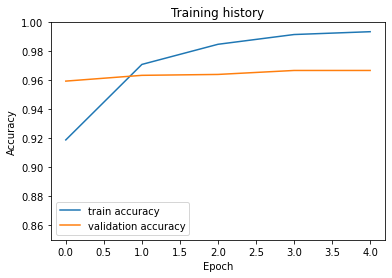

In [16]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.85, 1]);

In [17]:
def get_classification_report(test_data_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []
    with torch.no_grad():
        for data in tqdm(test_data_loader, total=len(test_data_loader)):
            pred_aspect_tags, loss = model(**data)
            
            final_pred_aspect_tags.extend(torch.argmax(pred_aspect_tags, dim=2))
            final_true_aspect_tags.extend(data['aspect_tags'])
            
    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
    
    # Remove the special -100 tokens 
    final_pred_aspect_tags = final_pred_aspect_tags[final_true_aspect_tags!=-100]
    final_true_aspect_tags = final_true_aspect_tags[final_true_aspect_tags!=-100]
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_data_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.task1.cleaned.bin


100%|██████████| 88/88 [00:04<00:00, 18.96it/s]

              precision    recall  f1-score   support

          AT       0.89      0.89      0.89      1826
         NAT       0.98      0.98      0.98      9475

    accuracy                           0.96     11301
   macro avg       0.93      0.93      0.93     11301
weighted avg       0.96      0.96      0.96     11301



In [18]:
def random_test(test_dataset, test_data_loader, model, num=5, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)
    
    with torch.no_grad():
        for i in range(num):
            
            data = next(iter(test_data_loader))
            
            pred_aspect_tags, _ = model(**data)
            
            
            input_ids = data['input_ids']
            pred_aspect_tags = torch.argmax(pred_aspect_tags, dim=2)
            true_aspect_tags = data['aspect_tags']
            mask = data['attention_mask']
            
            # Randomly pick a test data from this batch
            #
            rng = np.random.default_rng()
            idx = rng.integers(low=0, high=pred_aspect_tags.shape[0],size=1)[0]

            ids_array = input_ids[idx].cpu().numpy()
            pred_aspect_array = pred_aspect_tags[idx].cpu().numpy()
            true_aspect_array = true_aspect_tags[idx].cpu().numpy()
            mask_array = mask[idx].cpu().numpy()

            # Remove the padding as we do not want to print them
            #
            mask_array = np.logical_not(mask_array)

            # Only print the unpadded portion
            ids_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, ids_array))
            pred_aspect_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                       pred_aspect_array))
            true_aspect_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                       true_aspect_array))
            
            aspect_pred = pred_aspect_unpadded[true_aspect_unpadded!=-100]
            aspect_true = true_aspect_unpadded[true_aspect_unpadded!=-100]
            
            aspect_acc = np.sum(aspect_pred == aspect_true) / len(aspect_pred)
            
            # Remove begin and end
            ids_unpadded = ids_unpadded[1:-1]
            pred_aspect_unpadded = pred_aspect_unpadded[1:-1]
            true_aspect_unpadded = true_aspect_unpadded[1:-1]
            
            true_aspect_unpadded = np.where(true_aspect_unpadded==-100, 1, true_aspect_unpadded)

            orig_sentence = np.array(tokenizer.convert_ids_to_tokens(ids_unpadded))
            decoded_aspect_tags = encoder.inverse_transform(true_aspect_unpadded)
            aspect_tag_indices = decoded_aspect_tags == "AT"
            
            print("Aspect Acc: {:.2f}%".format(aspect_acc*100))
            print("Predicted Aspect:")
            print(encoder.inverse_transform(pred_aspect_unpadded))
            print("True Aspect:")
            print(decoded_aspect_tags)
            print("Sentence:")
            print(orig_sentence)   
            print("Aspect Terms: {}".format(orig_sentence[aspect_tag_indices]))
            print()


In [19]:
random_test(test_dataset, test_data_loader, model, num=10, model_path=MODEL_PATH)


Loading saved model from: model.task1.cleaned.bin
Aspect Acc: 100.00%
Predicted Aspect:
['NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT' 'NAT' 'NAT'
 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT']
True Aspect:
['NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT' 'NAT' 'NAT'
 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT']
Sentence:
['Some' 'problems' 'can' 'be' 'fixed' 'if' 'you' 'purchase' 'new'
 'software' 'but' 'there' 'is' 'no' 'g' '##ua' '##rent' '##ee']
Aspect Terms: ['software']

Aspect Acc: 90.00%
Predicted Aspect:
['NAT' 'AT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT' 'NAT' 'NAT' 'NAT' 'NAT']
True Aspect:
['NAT' 'AT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT']
Sentence:
['The' 'screen' 'almost' 'looked' 'like' 'a' 'bar' '##code' 'when' 'it'
 'froze']
Aspect Terms: ['screen']

Aspect Acc: 100.00%
Predicted Aspect:
['NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT'
 'AT' 'AT' 'AT' 'AT']
True Aspect:
['NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'NAT' 'AT' 'NAT' 'NAT' 'NAT' 'NAT' 

In [37]:
def test_dataset(idx=0):


    train_dataset = SentenceTagDataset(tokenizer=tokenizer,
                                       sentences=train_sentences,
                                       aspect_tags=train_aspect_tags,
#                                        polarity_tags=train_polarity_tags,
                                       aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())

    train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
        train_dataset, batch_size=32), device)    

    data = train_dataset[idx]
    input_ids = data['input_ids']
    attention_mask = np.logical_not(data['attention_mask'])
    aspect_tags = data['aspect_tags']
    
    print("*** Raw Data")
    print("*** input_ids")
    print(input_ids)
    print("*** aspect_tags")
    print(aspect_tags)
    print()
    
    input_ids = np.ma.compressed(np.ma.masked_where(attention_mask, input_ids))
    aspect_tags = np.ma.compressed(np.ma.masked_where(attention_mask, aspect_tags))
    
    aspect_tags = np.where(aspect_tags==-100, 1, aspect_tags)
    
    orig_sentence = np.array(train_dataset.tokenizer.convert_ids_to_tokens(input_ids))
    decoded_aspect_tags = encoder.inverse_transform(aspect_tags)
    
    aspect_tag_indices = decoded_aspect_tags == "AT"
    
    print(orig_sentence)
    print(decoded_aspect_tags)  
    
    print("Aspect Terms: {}".format(orig_sentence[aspect_tag_indices]))

test_dataset(1)

*** Raw Data
*** input_ids
tensor([  101,   146,  2965,  1122,  1120,  1480,  1105, 19476,  1781,  1103,
        13408,  1114,  1143,  1272,  1104,  1103,  1363,  7105,  1297,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  